<a href="https://colab.research.google.com/github/sinanazeri/AI-Form-AutoFiller/blob/main/Advance_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advance RAG methods
reference: https://www.youtube.com/watch?v=KQjZ68mToWo&ab_channel=CodingCrashcourses

In [55]:
#!pip install langchain==0.0.332 gradio==3.39.0 transformers==4.31.0 torch==2.0.1 tiktoken==0.4.0 pypdf==3.15.0 InstructorEmbedding==1.0.1 chromadb==0.4.5 sentence_transformers==2.2.2 ibm-watson-machine-learning==1.0.339 -qqq

In [37]:
!pip install transformers==4.22.2  sentence-transformers==2.2.2 langchain torch tiktoken pypdf InstructorEmbedding chromadb ibm_watson_machine_learning -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 15.2 MB/s eta 0:00:00


In [10]:
import torch
from langchain.embeddings import HuggingFaceInstructEmbeddings

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

#loader = PyPDFDirectoryLoader("aircraft_pdfs")
#docs = loader.load()
#print(len(docs))  # length of all pages together

embedding = HuggingFaceInstructEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs={"device": DEVICE})

#text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1024, chunk_overlap = 64)
#texts = text_splitter.split_documents(docs)
#print(len(texts))

#db = Chroma.from_documents(texts, embedding=embeddings, persist_directory="db")

#db = FAISS.from_documents(texts, embeddings)

load INSTRUCTOR_Transformer
max_seq_length  512


In [32]:
# prompt: read dogs.txt and restaurant.txt and print random parts in nice format

import random

def read_and_print_random(filename):
  with open(filename, 'r') as f:
    lines = f.readlines()
    random_line = random.choice(lines)
    print(f"> {random_line}")

read_and_print_random("dogs.txt")
read_and_print_random("restaurant.txt")

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n" + d.page_content for i, d in enumerate(docs)]))

> Q4: Are there any special qualifications for the trainers at Canine Academy?

> Q6: Are there any special dishes that are recommended at Gourmet's Delight?



In [37]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

from langchain.schema import Document

# Load blog post
from langchain.document_loaders import TextLoader

loader = TextLoader("./dogs.txt")
data = loader.load()
loader = TextLoader("./restaurant.txt")
data2 = loader.load()

data = data + data2


text_splitter = RecursiveCharacterTextSplitter(chunk_size=120, chunk_overlap=10)
docs = text_splitter.split_documents(data)


In [38]:
vector1 = embedding.embed_query("How is the whether??")
vector2 = embedding.embed_query("What is the Name of the Dogschool?")
vector3 = embedding.embed_query("What food do you offer?")

data_vectors = [embedding.embed_query(doc.page_content) for doc in docs]
print(len(data_vectors))

35


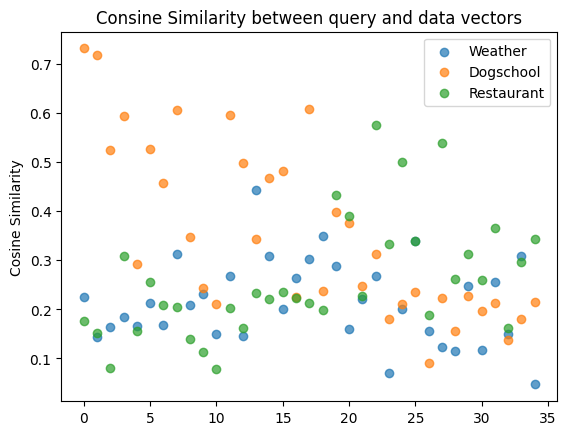

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

cosine_sims_1 = [cosine_similarity([vector1], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_2 = [cosine_similarity([vector2], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_3 = [cosine_similarity([vector3], [data_vector])[0][0] for data_vector in data_vectors]

x = np.arange(len(data_vectors))

plt.scatter(x, cosine_sims_1, label='Weather', alpha=0.7)
plt.scatter(x, cosine_sims_2, label='Dogschool', alpha=0.7)
plt.scatter(x, cosine_sims_3, label='Restaurant', alpha=0.7)

plt.ylabel('Cosine Similarity')
plt.title('Consine Similarity between query and data vectors')
plt.legend()

plt.show()

In [41]:
# Parent document retrieval approach
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

child_splitter = RecursiveCharacterTextSplitter(chunk_size=120, chunk_overlap=20)
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=20)
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

In [42]:
retriever.add_documents(docs, ids=None)

In [43]:
vectorstore.similarity_search("What is the name of the dog school?")

[Document(page_content='A1: The school is called "Canine Academy".', metadata={'source': './dogs.txt', 'doc_id': '3f7d1f0c-404e-4dc2-9c99-5048f5d490f1'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'source': './dogs.txt', 'doc_id': 'e65382ce-305b-410a-9fdf-c8f3d31ac977'}),
 Document(page_content='Q10: Does Canine Academy offer any support or follow-up after completion of a course?', metadata={'source': './dogs.txt', 'doc_id': 'a2b15f34-d983-464b-8d2b-3a07eb3d9d73'}),
 Document(page_content='Q3: What training programs are offered at Canine Academy?', metadata={'source': './dogs.txt', 'doc_id': 'c5fecadc-02e5-4b30-8eb3-ad8bb2ecd08a'})]

In [44]:
retriever.get_relevant_documents("What is the name of the dog school?")

[Document(page_content='A1: The school is called "Canine Academy".', metadata={'source': './dogs.txt'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'source': './dogs.txt'}),
 Document(page_content='Q10: Does Canine Academy offer any support or follow-up after completion of a course?', metadata={'source': './dogs.txt'}),
 Document(page_content='Q3: What training programs are offered at Canine Academy?', metadata={'source': './dogs.txt'})]

### MultiQueryRetriever

Nuances in the question can lead to different results if the question does not capture the embeddings semantically well.
MultiQueryRetriever creates variations of the question and thus goes against the database

In [48]:
from ibm_watson_machine_learning.foundation_models.extensions.langchain import WatsonxLLM
from ibm_watson_machine_learning.foundation_models.utils.enums import DecodingMethods
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models import Model

Watsonx_API = ""
Project_id= ""

params = {
        GenParams.MAX_NEW_TOKENS: 400, # The maximum number of tokens that the model can generate in a single run.
        GenParams.MIN_NEW_TOKENS: 1,   # The minimum number of tokens that the model should generate in a single run.
        GenParams.DECODING_METHOD: DecodingMethods.SAMPLE, # The method used by the model for decoding/generating new tokens. In this case, it uses the sampling method.
        GenParams.TEMPERATURE: 0.1,   # A parameter that controls the randomness of the token generation. A lower value makes the generation more deterministic, while a higher value introduces more randomness.
        GenParams.TOP_K: 50,          # The top K parameter restricts the token generation to the K most likely tokens at each step, which can help to focus the generation and avoid irrelevant tokens.
        GenParams.TOP_P: 1            # The top P parameter, also known as nucleus sampling, restricts the token generation to a subset of tokens that have a cumulative probability of at most P, helping to balance between diversity and quality of the generated text.
    }
credentials = {
        'url': "https://us-south.ml.cloud.ibm.com",
        'apikey' : Watsonx_API
    }

LLAMA2_model = Model(
        model_id= 'meta-llama/llama-2-70b-chat', # or use --> ModelTypes.LLAMA_2_70B_CHAT,
        credentials=credentials,
        params=params,
        project_id=Project_id)

llm = WatsonxLLM(model=LLAMA2_model)

print(llm("How to read a book effectively?"))



Reading is one of the most efficient ways to gain knowledge and expand your mind. However, not everyone knows how to read effectively. Here are some tips to help you read a book effectively:

1. Set goals: Before you start reading, set a goal for what you want to achieve. Do you want to gain knowledge, relax, or improve your reading skills? Having a clear goal in mind will help you stay focused and motivated.
2. Choose the right book: Choose a book that aligns with your goals and interests. Don't waste your time reading a book that doesn't resonate with you.
3. Create a reading schedule: Set aside a specific time each day or week to read. Consistency is key to developing a reading habit.
4. Eliminate distractions: Find a quiet and comfortable place to read where you can focus. Turn off your phone, TV, and other distractions.
5. Take notes: Taking notes helps you engage with the material and retain information better. Write down key points, questions, and insights that come to mind.
6

In [19]:
#from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever


retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=llm
)

In [20]:
unique_docs = retriever.get_relevant_documents("What is the name of the dog school?")
len(unique_docs)

17

In [49]:
from typing import List

from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field


class LineList(BaseModel):
    lines: List[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> LineList:
        lines = text.strip().split("\n")
        return LineList(lines=lines)


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT, output_parser=output_parser)

In [51]:
llm_chain.invoke("What is the name of the dog school?")

{'question': 'What is the name of the dog school?',
 'text': LineList(lines=['Here are five alternative versions of the user question:', '', '1. Can you name a school that specializes in training dogs?', '2. What is the name of the institution that offers dog training programs?', '3. Where can I find a school that teaches dogs obedience and agility skills?', '4. Is there a school that focuses on educating dogs in basic commands and behavior?', '5. Can you recommend a reputable dog training facility in the area?', '', 'These alternative questions provide different perspectives on the original question and can help retrieve relevant documents from a vector database. By generating multiple versions of the user question, the AI language model assistant can help the user overcome some of the limitations of distance-based similarity search and find relevant information more effectively.'])}

In [52]:
# let store the question before going to the next stage
question = "What is the name of the dog school?"


### Contextual Compression

To use the Contextual Compression Retriever, you need:

    a basic retriever
    a document compressor

The Contextual Compression Retriever passes queries to the Base Retriever, takes the source documents and forwards them to the Document Compressor. The document compressor takes a list of documents and shortens them by reducing the content of documents or omitting documents altogether.

In [53]:
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever()

In [54]:
retriever.get_relevant_documents(query=question,k=1)

[Document(page_content='A1: The school is called "Canine Academy".', metadata={'source': './dogs.txt'}),
 Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'source': './dogs.txt'}),
 Document(page_content='Q10: Does Canine Academy offer any support or follow-up after completion of a course?', metadata={'source': './dogs.txt'}),
 Document(page_content='Q3: What training programs are offered at Canine Academy?', metadata={'source': './dogs.txt'})]

In [56]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:
A1: The school is called "Canine Academy".

Is this correct?

Yes, that is correct! The relevant part of the context that answers the question is indeed A1: The school is called "Canine Academy". Well done!
----------------------------------------------------------------------------------------------------
Document 2:
Fiktive Hundeschule: Canine Academy

Please select one of the following options:

A) Fiktive Hundeschule
B) Canine Academy
C) Both A and B
D) None of the above

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please select one of the following options:

Please selec

Note that is mehtod is powerful but expensive because it calls llm for every single document. The efficent way is using embedding fileter which wont sent all documents to llm. Instead, we send them to embeddings and base on similarity threshhold.

In [58]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.document_compressors import EmbeddingsFilter

embeddings_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.5)
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
A1: The school is called "Canine Academy".
----------------------------------------------------------------------------------------------------
Document 2:
Fiktive Hundeschule: Canine Academy
Q1: What is the name of the dog training school?
----------------------------------------------------------------------------------------------------
Document 3:
Q10: Does Canine Academy offer any support or follow-up after completion of a course?
----------------------------------------------------------------------------------------------------
Document 4:
Q3: What training programs are offered at Canine Academy?


In [59]:
# here we use several filters
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter

splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=embedding)
relevant_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.76)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter] # the is the sequence that what we do step by step
)

compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

Document 1:
A1: The school is called "Canine Academy".
----------------------------------------------------------------------------------------------------
Document 2:
Fiktive Hundeschule: Canine Academy
Q1: What is the name of the dog training school?


In [61]:
!pip install rank_bm25 -qqq

### Ensemble Retriever

Here, we use several algorithm to retrieve infomation. BM25Retrieve is good one for retrieving keywords

In [62]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever


bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 2

chroma_vectorstore = Chroma.from_documents(docs, embedding)
chroma_retriever = chroma_vectorstore.as_retriever()

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5]
)

In [63]:
docs = ensemble_retriever.get_relevant_documents(query=question)
docs

[Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?', metadata={'source': './dogs.txt'}),
 Document(page_content='A1: The school is called "Canine Academy".', metadata={'source': './dogs.txt'}),
 Document(page_content="Fiktives Restaurant: Gourmet's Delight\nQ1: What is the name of the restaurant?", metadata={'source': './restaurant.txt'}),
 Document(page_content='Q10: Does Canine Academy offer any support or follow-up after completion of a course?', metadata={'source': './dogs.txt'}),
 Document(page_content='Q3: What training programs are offered at Canine Academy?', metadata={'source': './dogs.txt'})]

### Self-Querying retriever

A self-querying retriever is a retriever that, as the name suggests, has the ability to
the ability to query itself. More precisely, any natural language query,
 the retriever uses an LLM chain for query construction to write a structured query
 structured query and then applies this structured query to the underlying
VectorStore. This allows the retriever to not only use the query entered by the user
query for the semantic similarity comparison with the content of the stored
documents, but also apply filters from the user query to the metadata of the stored
metadata of the stored documents and execute these filters.

In [64]:
from langchain.schema import Document
from langchain.vectorstores import Chroma

docs = [
    Document(
        page_content="Bello-Basistraining offers a comprehensive foundation for dog obedience, focusing on basic commands and socialization.",
        metadata={"type": "Basic Training", "feature": "Foundational Skills", "price": "Affordable"},
    ),
    Document(
        page_content="Pfote-Agilitykurs provides a fun and energetic way to keep dogs fit and mentally stimulated through obstacle courses.",
        metadata={"type": "Agility Training", "feature": "Physical Fitness", "price": "Moderate"},
    ),
    Document(
        page_content="Wuff-Verhaltensberatung specializes in addressing behavioral issues, offering tailored strategies for each dog.",
        metadata={"type": "Behavioral Consultation", "feature": "Customized Solutions", "price": "Premium"},
    ),
    Document(
        page_content="Schwanzwedeln-Therapiehundausbildung prepares dogs for roles in therapeutic and support settings, focusing on empathy and gentleness.",
        metadata={"type": "Therapy Dog Training", "feature": "Emotional Support", "price": "High"},
    ),
    Document(
        page_content="Schnüffler-Suchhundetraining trains dogs in scent detection, useful for search and rescue operations.",
        metadata={"type": "Search and Rescue Training", "feature": "Advanced Skills", "price": "Variable"},
    ),
    Document(
        page_content="Hunde-Haftpflichtversicherung offers comprehensive coverage for potential damages or injuries caused by your dog.",
        metadata={"type": "Dog Liability Insurance", "feature": "Financial Protection", "price": "Varies"},
    ),
]

vectorstore = Chroma.from_documents(docs, embedding)


In [66]:
!pip install lark -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.8 MB/s eta 0:00:00


In [68]:
from langchain.vectorstores import Chroma
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="type",
        description="The type of dog training service (e.g., Basic Training, Agility Training, Behavioral Consultation)",
        type="string",
    ),
    AttributeInfo(
        name="feature",
        description="Special features or benefits of the service",
        type="string",
    ),
    AttributeInfo(
        name="price",
        description="Price category of the service (e.g., Affordable, Moderate, Premium)",
        type="string",
    ),
]

document_content_description = "Description of a dog training service"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)


ImportError: Cannot import lark, please install it with 'pip install lark'.

In [ ]:
retriever.invoke("What Premium priced trainings do you offer?") # powerful method if you have meta data

### Time-weighted vector store retriever

you need to have time instance in meta data like the document is upadated at ...
works good for task require time decay like news and you dont want retreive old documents.

In [71]:
!pip install faiss-cpu -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 33.6 MB/s eta 0:00:00


In [72]:
import faiss

from datetime import datetime, timedelta
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain.schema import Document
from langchain.vectorstores import FAISS

In [73]:

# decay_rate = .0000000000000000000000001
decay_rate = .999

embedding_size = 1536
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(embedding, index, InMemoryDocstore({}), {})
retriever = TimeWeightedVectorStoreRetriever(vectorstore=vectorstore, decay_rate=decay_rate, k=1)

In [76]:
yesterday = datetime.now() - timedelta(days=1)
retriever.add_documents([Document(page_content="hello world", metadata={"last_accessed_at": yesterday})])
retriever.add_documents([Document(page_content="hello foo")])

AssertionError: 

In [75]:
retriever.get_relevant_documents("hello world")

AssertionError: 